In [1]:
# Lets import some libraries
import os

import torch
#import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import time

In [2]:
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'D:\DNN\images' # location of the images
modelDir = '../models'
altName = '?????'
modelSubDir = 'pytorch_fashion'

RANDOM_STATE = 24

torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
PATIANCE=10
EPOCHS = 15 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
NUM_BATCHES = 6 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # 

plt.cm.Spectral

plt.rcParams.update(params)

In [3]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    

In [4]:
###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [5]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename,header=0)
test_df = pd.read_csv(test_filename,header=0)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class_labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}

In [7]:
train_df.shape

(60000, 785)

In [8]:
def split_feature_label(row):
    feature = tf.reshape(row[1:],[28,28,1])
    label = row[0]
    return feature,label

In [9]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)

# What is he data?

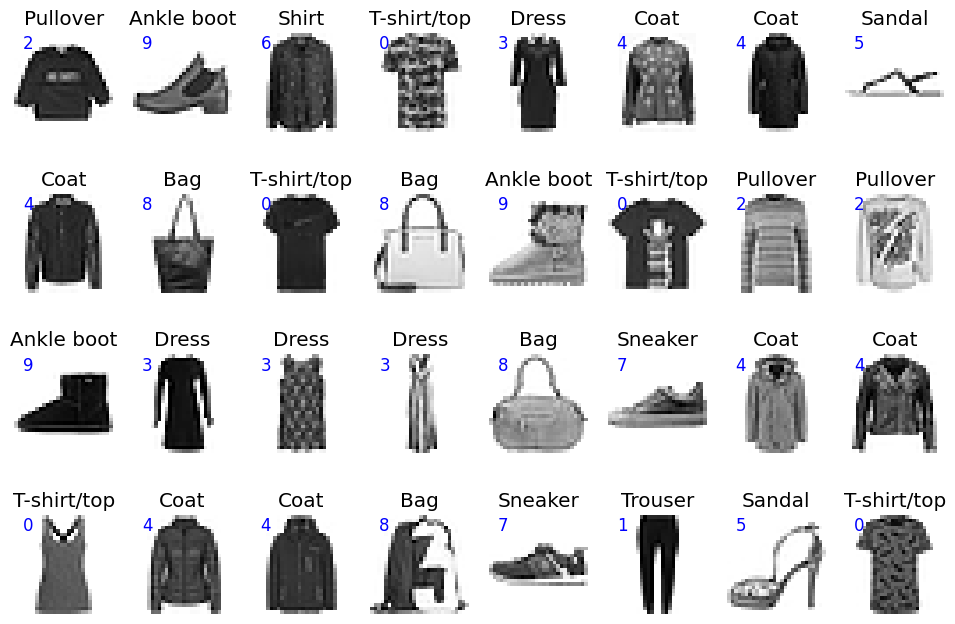

In [10]:
#sample data plot
fig = plt.figure(figsize=(12,8))
for images,labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4,int(BATCH_SIZE//4),i+1)
        plt.imshow(images[i].numpy(),cmap=plt.cm.binary,interpolation='nearest')
        plt.title(class_labels[labels[i].numpy()])
        plt.text(2,4,labels[i].numpy(),color = 'b',fontsize=12)
        plt.axis('off')

In [11]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

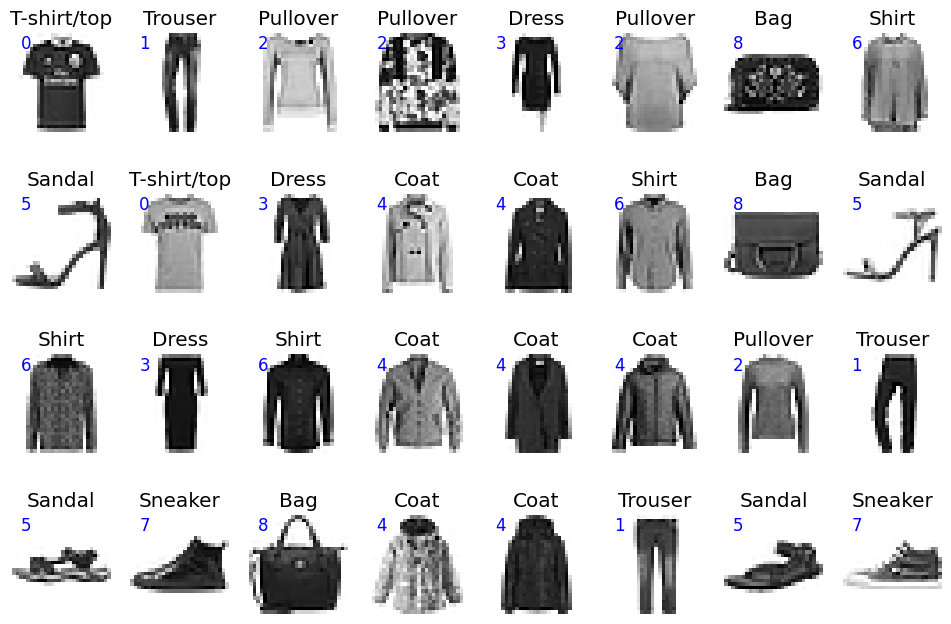

In [12]:
#sample data plot
fig = plt.figure(figsize=(12,8))
for images,labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4,int(BATCH_SIZE//4),i+1)
        plt.imshow(images[i].numpy(),cmap=plt.cm.binary,interpolation='nearest')
        plt.title(class_labels[labels[i].numpy()])
        plt.text(2,4,labels[i].numpy(),color = 'b',fontsize=12)
        plt.axis('off')

In [13]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# In subsequent copies,delete these lines

# Define Model

In [14]:
reg_lambda = 0.005
#knl_reg = tf.keras.regularizers.L2(reg_lambda)
knl_reg=None
dor1 = 0.2
dor2 = 0.2
dor3 = 0.2
dor4 = 0.2

model = tf.keras.Sequential()
#Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

# Set -1

model.add(tf.keras.layers.Conv2D(32,3,
                                 padding='same',
                                 use_bias=False,
                                 kernel_regularizer=knl_reg,
                                 input_shape=(28,28,1)))  # 28 x 28 x 32


model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ReLU())
#model.add(tf.keras.layers.Activations())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 14 x 14 x 32

#model.add(tf.keras.layers.Dropout(dor1))

# Set -2

model.add(tf.keras.layers.Conv2D(64,3,
                                 use_bias=False,
                                kernel_regularizer=knl_reg))  # 12 x 12 x 64

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))  # 6 x 6 x 64
#model.add(tf.keras.layers.Dropout(dor2))


# Set -3 

model.add(tf.keras.layers.Conv2D(128,3))  # 4 x 4 x 128

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.ReLU())
#model.add(tf.keras.layers.Dropout(dor3))

# Head

In [15]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
# model.add(tf.keras.layers.Dropout(dor4))
model.add(tf.keras.layers.Dense(10))

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelDir,
    monitor = 'val_loss',
    mode='auto',
    baseline = None,
    save_best_only = True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIANCE,
    mode='auto',
    baseline = None,
    restore_best_weights = True
)

# learning_rate_callback  = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=ALPHA,
#     patience=PATIANCE,
#     verbose=2,
#     mode='auto',
#     min_lr=0.00001,
# )

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks = [model_checkpoint_callback,early_stopping_callback],
                    validation_data=test_ds)


Epoch 1/15


1875/1875 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8665INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


1875/1875 [==============================] - 39s 19ms/step - loss: 0.3683 - accuracy: 0.8665 - val_loss: 0.3712 - val_accuracy: 0.8603
Epoch 2/15
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2468 - accuracy: 0.9091 - val_loss: 0.4305 - val_accuracy: 0.8388
Epoch 3/15
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2003 - accuracy: 0.9258 - val_loss: 0.4220 - val_accuracy: 0.8545
Epoch 4/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1659 - accuracy: 0.9391 - val_loss: 0.4450 - val_accuracy: 0.8569
Epoch 5/15
1872/1875 [============================>.] - ETA: 0s - loss: 0.1377 - accuracy: 0.9498INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


1875/1875 [==============================] - 32s 17ms/step - loss: 0.1376 - accuracy: 0.9498 - val_loss: 0.2789 - val_accuracy: 0.9055
Epoch 6/15
1874/1875 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9591INFO:tensorflow:Assets written to: ..\models\assets


INFO:tensorflow:Assets written to: ..\models\assets


1875/1875 [==============================] - 31s 17ms/step - loss: 0.1128 - accuracy: 0.9592 - val_loss: 0.2638 - val_accuracy: 0.9155
Epoch 7/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0954 - accuracy: 0.9654 - val_loss: 0.2885 - val_accuracy: 0.9149
Epoch 8/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0815 - accuracy: 0.9697 - val_loss: 0.3085 - val_accuracy: 0.9162
Epoch 9/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0681 - accuracy: 0.9746 - val_loss: 0.3317 - val_accuracy: 0.9124
Epoch 10/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0624 - accuracy: 0.9766 - val_loss: 0.3567 - val_accuracy: 0.9180
Epoch 11/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0532 - accuracy: 0.9807 - val_loss: 0.4230 - val_accuracy: 0.9070
Epoch 12/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0477 - accuracy: 0.9822 - val_loss: 0.4265 - val_acc

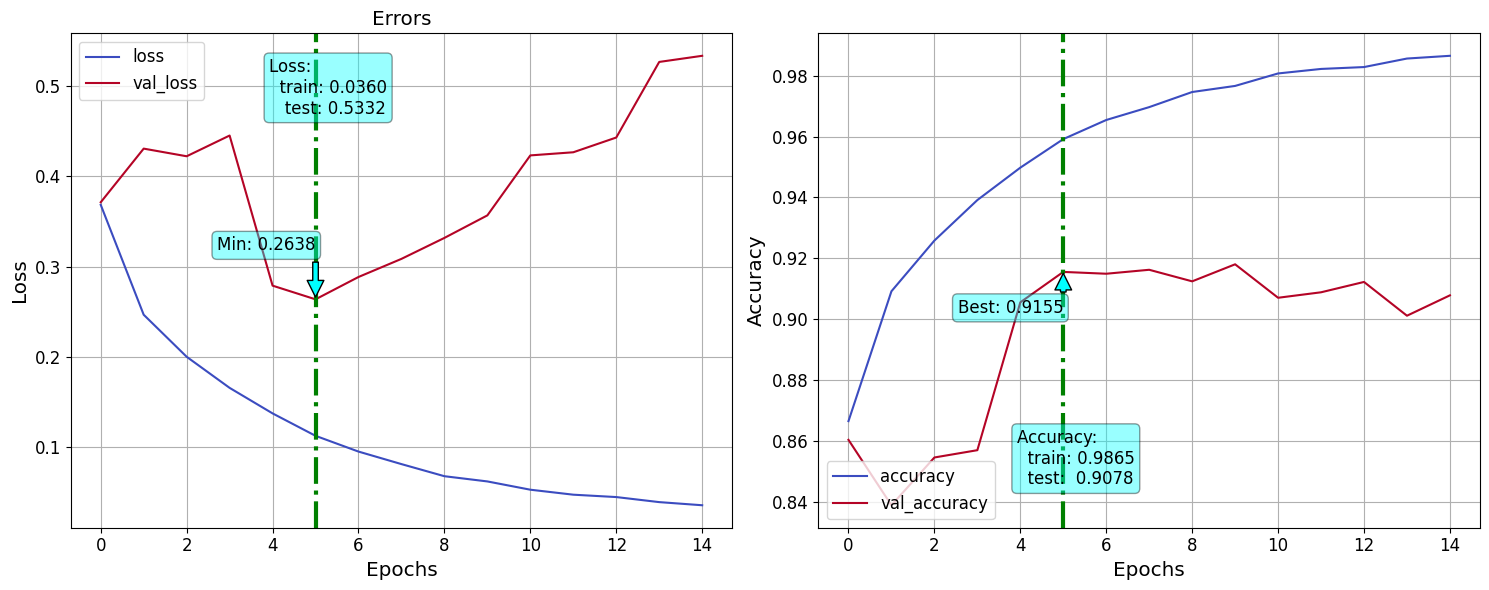

In [18]:
fn_plot_tf_hist(pd.DataFrame(history.history))